In [1]:
from keras.models import Model
from keras.layers import Input
from keras.optimizers import *
from keras.datasets import mnist
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Local imports
from unet import unet_cell, LEAKY_RELU_ALPHA, BATCH_NORM_MOMENTUM
from builders import build_upscaler, build_upscaler_v2, build_discriminator
from utils import reduce_resolution

batch_size = 100
n_channels = 1
GRADIENT_PENALTY_WEIGHT = 10
import WGAN_utils
from WGAN_utils import wasserstein_loss, gradient_penalty_loss, RandomWeightedAverage
WGAN_utils.batch_size=batch_size

Using TensorFlow backend.


In [2]:
# Load MNIST training data
(X_train, _), (_, _) = mnist.load_data() # No need for labels or test set
X_train = X_train.reshape(-1, 28, 28, 1)
X_train = X_train / 255.0 # Normalize

In [1]:
# Define inputs
low_res_input = Input(shape=(None, None, 1))
# TODO: dimensions of low_res_input should probably be divisible 
# by 2**{num_layers}
high_res_input = Input(shape=(None, None, 1)) # This should really have dimensions twice that of low_res_input

# Build upscaler / discriminator
upscaler = build_upscaler_v2(
    low_res_input,
    output_size=(28, 28),
    resize_method='nearest_neighbor',
    align_corners=True,
    num_filters_in_layer=[16, 32, 64, 32],
    num_cells_in_layer=[3, 3, 3, 3],
    bottleneck_before_concat=True)
preliminary_discriminator = build_discriminator(low_res_input, high_res_input, 
                                                use_batch_norm=False, 
                                                activation_in_final_layer=False) # Use default parameters


# Define optimizers and compile models
upscaler_optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
upscaler.compile(loss='binary_crossentropy', 
                 optimizer=upscaler_optimizer)

# Defines the forward pass for the discriminator.  This will be used for the combined
# model when training the generator, but the gradient loss function still has to
# be defined so it can be used in training the discriminator.  This model will
# be used to calculate the gradient loss and so has to be compiled now.
discriminator_optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
preliminary_discriminator.compile(loss='binary_crossentropy', 
                      optimizer=discriminator_optimizer, 
                      metrics=['accuracy'])

# We will compile the discriminator model before the combined model for the generator
# so the generator's weights should be frozen.
preliminary_discriminator.trainable = True
upscaler.trainable = False

# We need sample images produced by the generator and so that we can take a weighted
# average of the generated images and the real images to stochastically determine the
# effective gradients by passing this weighted average through the discriminator. We
# also use the inputs and outputs defined here to define the full discriminator model.
generator_input = Input(shape=(None, None, 1))
generated_samples = upscaler(generator_input)
discriminator_output_from_generator = preliminary_discriminator([generator_input, generated_samples])

low_res_input_for_discriminator = Input(shape=(None, None, 1))
real_samples = Input(shape=(None, None, 1))
discriminator_output_from_real_samples = preliminary_discriminator([low_res_input_for_discriminator, real_samples])

# We also need to generate weighted-averages of real and generated samples, to use for the gradient norm penalty.
averaged_samples = RandomWeightedAverage()([real_samples, generated_samples])
# We then run these samples through the discriminator as well. Note that we never really use the discriminator
# output for these samples - we're only running them to get the gradient norm for the gradient penalty loss.
averaged_samples_out = preliminary_discriminator([generator_input, averaged_samples])

# The gradient penalty loss function requires the input averaged samples to get gradients. However,
# Keras loss functions can only have two arguments, y_true and y_pred. We get around this by making a partial()
# of the function with the averaged samples here.
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gradient_penalty'  # Functions need names or Keras will throw an error

# Define model and compile it
discriminator = Model(inputs=[generator_input, low_res_input_for_discriminator, real_samples],
                            outputs=[discriminator_output_from_generator,
                                     discriminator_output_from_real_samples,
                                     averaged_samples_out])

discriminator.compile(optimizer=discriminator_optimizer,
                            loss=[wasserstein_loss,
                                  wasserstein_loss,
                                  partial_gp_loss], 
                      metrics = None)

# Freeze the discriminator weights and allow the generator to train
preliminary_discriminator.trainable = False
upscaler.trainable = True

# Define the input and output of the combined model.
low_res_input_for_combined_model = Input(shape=(None, None, 1))
upscaled_imgs = upscaler(low_res_input_for_combined_model)
valid = preliminary_discriminator([low_res_input_for_combined_model, upscaled_imgs])

# The combined model  (stacked upscaler and discriminator) takes
# low-res image as input and returns an upsampled image from the 
# upscaler and a validity score given by the discriminator
combined = Model(low_res_input_for_combined_model, [valid, upscaled_imgs])
combined.compile(loss=[wasserstein_loss, 'mean_absolute_error'], 
                 optimizer=upscaler_optimizer, 
                 metrics = None)
# Notice: the combined model was compiled *after* freezing the discriminator's weights

print('combined summary')
combined.summary()
print('discriminator summary')
discriminator.summary()
print('preliminary_discriminator summary')
preliminary_discriminator.summary()
print('upscaler summary')
upscaler.summary()

NameError: name 'Input' is not defined

In [4]:
# Define training parameters
train_steps = 1000
print_every_n_steps = 20
print_results = True
plot_results = True
repeat_discriminator_training_n_times = 1
# batch_size defined in first cell

# Create a dictionary for storing training metrics over time
training_metrics = {
    'step': [],
    'd_loss': [],
    'd_acc': [],
    'g_loss': []
}

# We make three label vectors for training. positive_y is the label vector for real samples, with value 1.
# negative_y is the label vector for generated samples, with value -1. The dummy_y vector is passed to the
# gradient_penalty loss function and is not used.
positive_y = np.ones((batch_size, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step 20:
    [D loss: 8.599944, accuracy: -0.8626]
    [G loss: 1.438437]


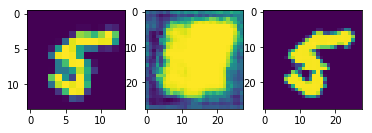

Step 40:
    [D loss: 0.073332, accuracy: -11.4826]
    [G loss: 12.483880]


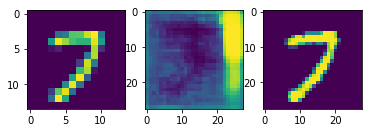

Step 60:
    [D loss: -0.289533, accuracy: -10.6288]
    [G loss: 11.138860]


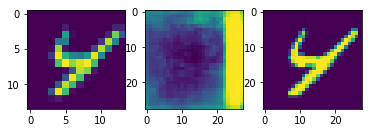

Step 80:
    [D loss: -2.495514, accuracy: -11.3616]
    [G loss: 11.453980]


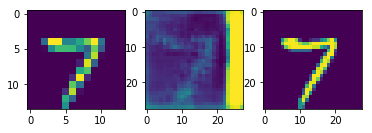

Step 100:
    [D loss: -3.653534, accuracy: -11.5257]
    [G loss: 11.915049]


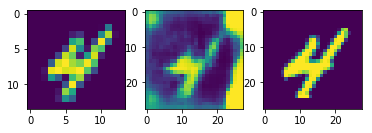

Step 120:
    [D loss: -3.817353, accuracy: -12.4781]
    [G loss: 12.539573]


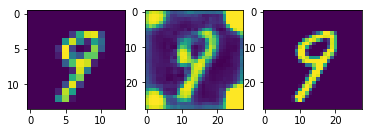

Step 140:
    [D loss: -4.950846, accuracy: -12.5472]
    [G loss: 12.904732]


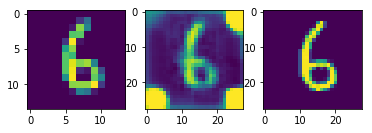

Step 160:
    [D loss: -5.804057, accuracy: -16.0219]
    [G loss: 17.180229]


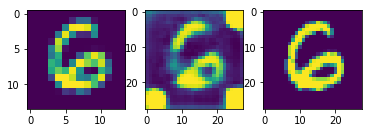

Step 180:
    [D loss: -4.849765, accuracy: -15.4808]
    [G loss: 13.306102]


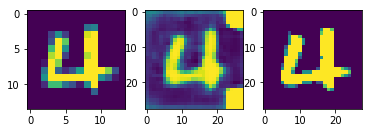

Step 200:
    [D loss: -6.173278, accuracy: -16.1068]
    [G loss: 16.979107]


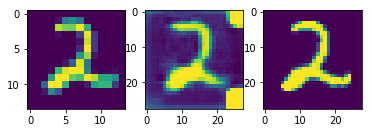

Step 220:
    [D loss: -5.706830, accuracy: -16.6528]
    [G loss: 14.945392]


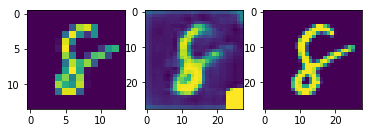

Step 240:
    [D loss: -6.147264, accuracy: -13.3966]
    [G loss: 14.953174]


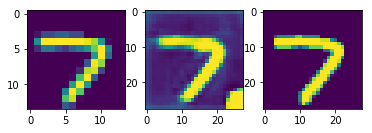

Step 260:
    [D loss: -5.015076, accuracy: -14.3944]
    [G loss: 13.563641]


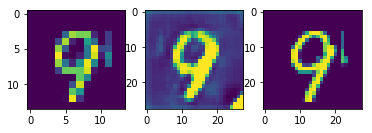

Step 280:
    [D loss: -4.170463, accuracy: -13.1239]
    [G loss: 14.082687]


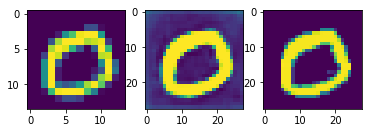

Step 300:
    [D loss: -4.268034, accuracy: -13.4364]
    [G loss: 13.006562]


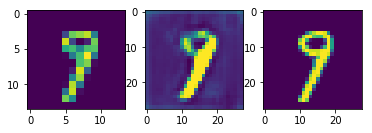

Step 320:
    [D loss: -3.816468, accuracy: -12.3245]
    [G loss: 11.606823]


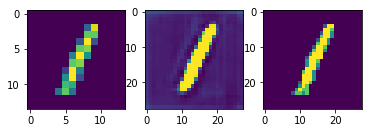

Step 340:
    [D loss: -4.032105, accuracy: -11.4033]
    [G loss: 11.943587]


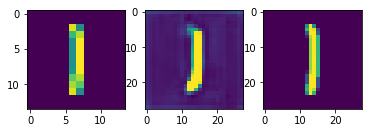

Step 360:
    [D loss: -3.654317, accuracy: -11.4572]
    [G loss: 10.597156]


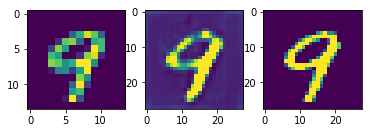

Step 380:
    [D loss: -3.568832, accuracy: -10.2353]
    [G loss: 11.133053]


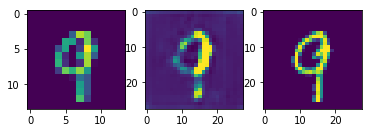

Step 400:
    [D loss: -3.431731, accuracy: -10.0730]
    [G loss: 10.688896]


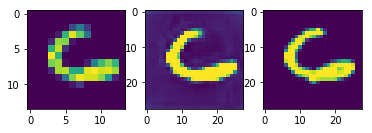

Step 420:
    [D loss: -3.342219, accuracy: -10.8658]
    [G loss: 10.621288]


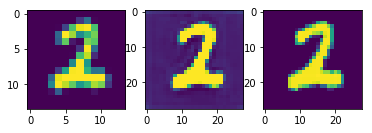

Step 440:
    [D loss: -3.296233, accuracy: -8.4908]
    [G loss: 9.833017]


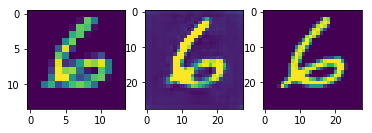

Step 460:
    [D loss: -3.122194, accuracy: -8.8144]
    [G loss: 9.010925]


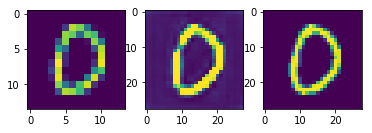

Step 480:
    [D loss: -3.120605, accuracy: -8.1964]
    [G loss: 9.225020]


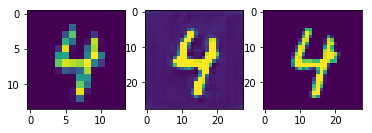

Step 500:
    [D loss: -2.720022, accuracy: -8.9723]
    [G loss: 8.260398]


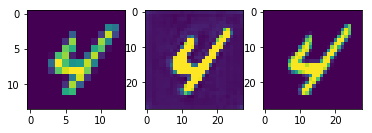

Step 520:
    [D loss: -2.698439, accuracy: -8.6232]
    [G loss: 8.012918]


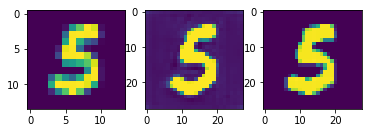

Step 540:
    [D loss: -2.799783, accuracy: -9.0465]
    [G loss: 7.959150]


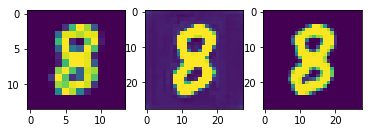

Step 560:
    [D loss: -2.484344, accuracy: -9.0756]
    [G loss: 8.644832]


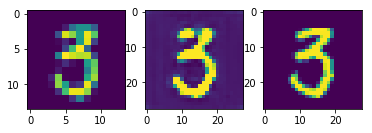

Step 580:
    [D loss: -2.586012, accuracy: -8.9607]
    [G loss: 8.800954]


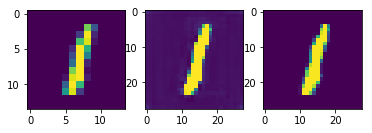

Step 600:
    [D loss: -2.514537, accuracy: -9.9235]
    [G loss: 9.337801]


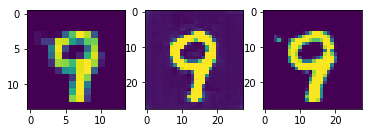

Step 620:
    [D loss: -2.431870, accuracy: -8.9184]
    [G loss: 9.790100]


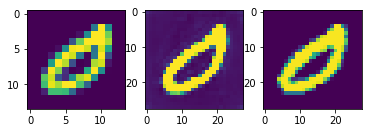

Step 640:
    [D loss: -2.405751, accuracy: -9.2988]
    [G loss: 9.227243]


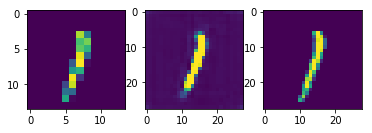

Step 660:
    [D loss: -2.296833, accuracy: -9.3479]
    [G loss: 8.629094]


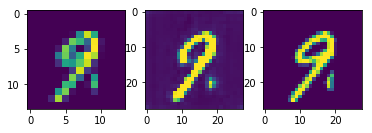

Step 680:
    [D loss: -2.233853, accuracy: -8.7901]
    [G loss: 8.236881]


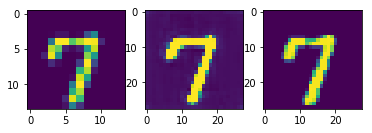

Step 700:
    [D loss: -2.189978, accuracy: -8.2557]
    [G loss: 8.225383]


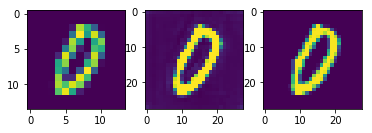

Step 720:
    [D loss: -2.222083, accuracy: -8.3136]
    [G loss: 8.318858]


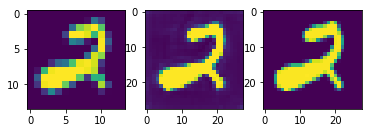

Step 740:
    [D loss: -2.092082, accuracy: -8.5140]
    [G loss: 7.619169]


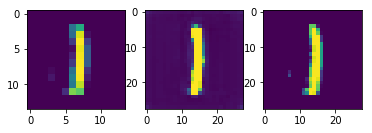

Step 760:
    [D loss: -1.920029, accuracy: -7.0285]
    [G loss: 8.031842]


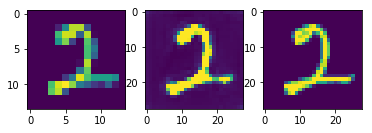

Step 780:
    [D loss: -1.965934, accuracy: -7.4917]
    [G loss: 7.708703]


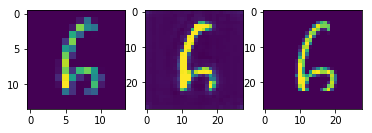

Step 800:
    [D loss: -1.804210, accuracy: -8.7442]
    [G loss: 9.140137]


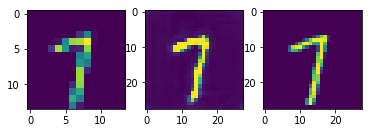

Step 820:
    [D loss: -1.717722, accuracy: -7.4491]
    [G loss: 8.114943]


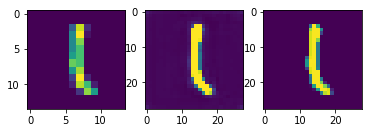

Step 840:
    [D loss: -1.671751, accuracy: -8.8377]
    [G loss: 7.307237]


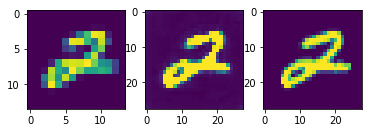

Step 860:
    [D loss: -1.629918, accuracy: -8.6390]
    [G loss: 8.629929]


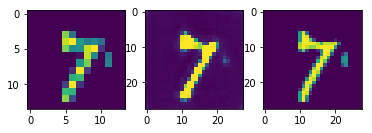

Step 880:
    [D loss: -1.705737, accuracy: -8.2826]
    [G loss: 7.796538]


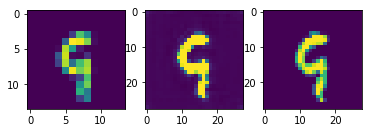

Step 900:
    [D loss: -1.499873, accuracy: -7.8630]
    [G loss: 8.795852]


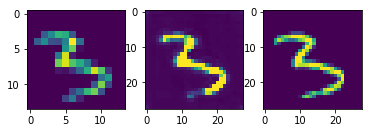

Step 920:
    [D loss: -1.390937, accuracy: -8.8550]
    [G loss: 8.526834]


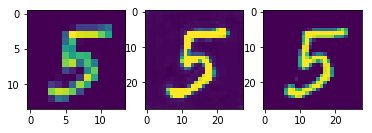

Step 940:
    [D loss: -1.523524, accuracy: -9.5606]
    [G loss: 9.403490]


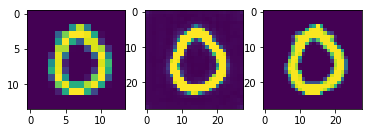

Step 960:
    [D loss: -1.317451, accuracy: -9.9726]
    [G loss: 9.950934]


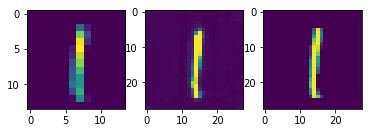

Step 980:
    [D loss: -1.413203, accuracy: -9.2890]
    [G loss: 9.210785]


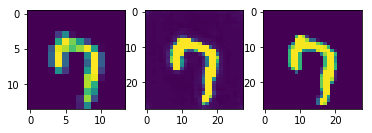

Step 1000:
    [D loss: -1.266803, accuracy: -9.4864]
    [G loss: 8.028327]


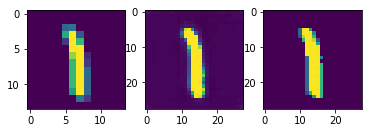

In [5]:
for step in range(1, train_steps + 1):
    
    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    num_images = len(X_train)
    for train_discriminator in range(repeat_discriminator_training_n_times):
        random_idxs = np.random.randint(num_images, size=batch_size)
        imgs_to_pass_through_upscaler = X_train[random_idxs]
        low_res_imgs_to_pass_through_upscaler = reduce_resolution(imgs_to_pass_through_upscaler)

        random_idxs = np.random.randint(num_images, size=batch_size)
        real_imgs = X_train[random_idxs]
        low_res_imgs_to_pass_through_discriminator = reduce_resolution(real_imgs)

        # Train the discriminator
        d_loss = discriminator.train_on_batch( 
            x=[low_res_imgs_to_pass_through_upscaler, low_res_imgs_to_pass_through_discriminator, real_imgs], # Training data
            y=[negative_y, positive_y, dummy_y]) # Labels
    
    # ---------------------
    #  Train upscaler
    # ---------------------

    random_idxs = np.random.randint(num_images, size=batch_size)
    original_imgs = X_train[random_idxs]
    new_low_res_imgs = reduce_resolution(original_imgs)
    
    # Train the upscaler
    g_loss = combined.train_on_batch(
        x=new_low_res_imgs, 
        y=[positive_y, original_imgs])
        
    if step % print_every_n_steps == 0:
        # Store metrics over time
        training_metrics['step'].append(step)
        training_metrics['d_loss'].append(d_loss[0])
        training_metrics['d_acc'].append(d_loss[1])
        training_metrics['g_loss'].append(g_loss[0])
        
        # Print current metrics
        if print_results:
            print("Step {}:".format(step))
            print("    [D loss: {:0.6f}, accuracy: {:0.4f}]".format(
                training_metrics['d_loss'][-1],
                training_metrics['d_acc'][-1]))
            print("    [G loss: {:0.6f}]".format(
                training_metrics['g_loss'][-1]))
        
        # Plot example low_res vs upsampling vs original
        if plot_results:
            gen_imgs = upscaler.predict(low_res_imgs_to_pass_through_discriminator)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(low_res_imgs_to_pass_through_discriminator[0, :, :, 0])
            ax2.imshow(gen_imgs[0, :, :, 0])
            ax3.imshow(real_imgs[0, :, :, 0])
            plt.show()

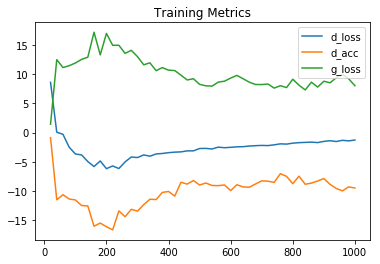

In [6]:
steps = training_metrics['step']
for key, values in training_metrics.items():
    if key == 'step': continue
    plt.plot(steps, values, label=key)
plt.title('Training Metrics')
plt.legend();

In [7]:
def save_models():
    upscaler.save('./models/upscaler_mnist.h5')
    discriminator.save('./models/discriminator_mnist.h5')
    combined.save('./models/combined_mnist.h5')

In [8]:
def show_examples():
    from keras.models import load_model

    # Load the upscaler
    upscaler = load_model('./models/upscaler_mnist.h5')

    # Upsample five images
    fi = 314 # First index
    images = X_train[fi:fi + 5]
    upsampled = upscaler.predict(images)
    upupsampled = upscaler.predict(upsampled)

    # Create a figure showing the results
    for i, (original, up, upup) in enumerate(zip(images, upsampled, upupsampled)):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        if i == 0:
            fig.suptitle("Original vs Upsampled vs Twice Upsampled")
        ax1.imshow(original[:, :, 0])
        ax2.imshow(up[:, :, 0])
        ax3.imshow(upup[:, :, 0])
        plt.show()

In [9]:
# save_models()
# show_examples()

# Transfering weights to model that produces larger outputs

In [10]:
# Define inputs
low_res_input = Input(shape=(None, None, 1))

# Build upscaler with different output size
new_upscaler = build_upscaler_v2(
    low_res_input,
    output_size=(128, 128),  # Previous output size was (28, 28)
    resize_method='bicubic', # Notice: We've even changed resize method from NN to bicubic
    align_corners=True,
    num_filters_in_layer=[16, 32, 64, 32],
    num_cells_in_layer=[3, 3, 3, 3],
    bottleneck_before_concat=True)

# Compile the new upscaler
new_upscaler_optimizer = Adam(0.001, 0.5)
new_upscaler.compile(loss='binary_crossentropy', 
                     optimizer=new_upscaler_optimizer)

# Transfer weights from original upscaler to new upscaler
for new_layer, pretrained_layer in zip(new_upscaler.layers, upscaler.layers):
    learned_weights = pretrained_layer.get_weights()
    new_layer.set_weights(learned_weights)

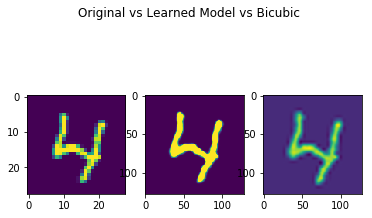

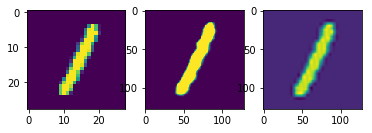

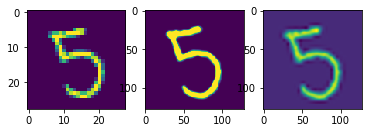

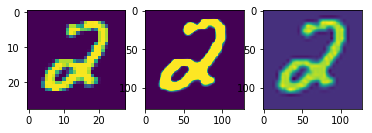

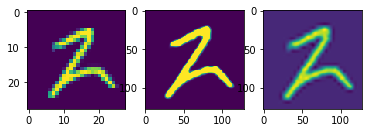

In [11]:
fi = 314 # First index
images = X_train[fi:fi+5] # Select five images
upsampled = new_upscaler.predict(images)

# Compare our model to vanilla bicubic resize:
with tf.Session() as sess:
    bicubic = sess.run(tf.image.resize_bicubic(images, (128, 128), align_corners=True))

# Create a figure showing the results
for i, (original, up, control) in enumerate(zip(images, upsampled, bicubic)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    if i == 0:
        fig.suptitle("Original vs Learned Model vs Bicubic")
    ax1.imshow(original[:, :, 0])
    ax2.imshow(up[:, :, 0])
    ax3.imshow(control[:, :, 0])
    plt.show()